In [1]:
# Celda 1 - Imports, rutas y carga de datos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path
import unicodedata
import re

BASE_DIR = Path("..")
PROCESSED_DIR = BASE_DIR / "processed"
GEO_PATH = BASE_DIR / "data" / "geojson" / "colombia_departamentos.json"

# Dataset limpio del libro 01
df = pd.read_csv(PROCESSED_DIR / "suelos_clean.csv")

print("Dataset cargado:", df.shape)
df.head()


Dataset cargado: (35111, 40)


C:\Users\diego\AppData\Local\Temp\ipykernel_34468\2504386150.py:17: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PROCESSED_DIR / "suelos_clean.csv")


,secuencial,fecha_de_an_lisis,departamento,municipio,cultivo,estado,tiempo_de_establecimiento,topografia,drenaje,riego,...,manganeso_disponible_doble_acido,zinc_disponible_doble_acido,acidez_intercambiable,cic,hierro_olsen,manganeso_olsen,zinc_olsen,hierro_doble_acido,manganeso_doble_acido,zinc_doble_acido
0,1,2014-07-01,NARIÑO,SAN ANDRÉS DE TUMACO,No Indica,No indica,No indica,No indica,No indica,No indica,...,ND,ND,NaN,2.094,66.39,1.700,1.500,NaN,NaN,NaN
1,164,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Plano,Buen drenaje,Aspersión,...,ND,ND,NaN,11.490,222.00,3.599,2.500,NaN,NaN,NaN
2,165,2014-05-09,CUNDINAMARCA,UNE,Lulo,Establecido,De 0 a 1 año,Ondulado,Buen drenaje,Aspersión,...,ND,ND,NaN,12.660,345.00,3.900,7.000,NaN,NaN,NaN
3,166,2014-05-09,CUNDINAMARCA,FUNZA,Guisantes,Por establecer,No indica,Plano,Buen drenaje,Goteo,...,ND,ND,NaN,7.303,102.00,3.599,7.500,NaN,NaN,NaN
4,167,2014-05-09,VALLE DEL CAUCA,LA UNIÓN,Guanábana,Establecido,Mas de 10 años,Plano,Buen drenaje,Manguera,...,ND,ND,NaN,22.770,8.10,0.800,1.799,NaN,NaN,NaN


In [2]:
# Celda 2 - Lista de variables de suelo y variables presentes

VARIABLES_SUELO = [
    "ph_agua_suelo", "materia_organica", "fosforo_bray_ii", "azufre_fosfato_monocalcico",
    "acidez_intercambiable", "aluminio_intercambiable", "calcio_intercambiable",
    "magnesio_intercambiable", "potasio_intercambiable", "sodio_intercambiable", "cic",
    "conductividad_electrica", "hierro_olsen", "cobre_disponible", "manganeso_olsen",
    "zinc_olsen", "boro_disponible", "hierro_doble_acido", "cobre_doble_acido",
    "manganeso_doble_acido", "zinc_doble_acido"
]

variables_presentes = [v for v in VARIABLES_SUELO if v in df.columns]

print(f"Variables presentes ({len(variables_presentes)}):")
variables_presentes


Variables presentes (20):


['ph_agua_suelo',
 'materia_organica',
 'fosforo_bray_ii',
 'azufre_fosfato_monocalcico',
 'acidez_intercambiable',
 'aluminio_intercambiable',
 'calcio_intercambiable',
 'magnesio_intercambiable',
 'potasio_intercambiable',
 'sodio_intercambiable',
 'cic',
 'conductividad_electrica',
 'hierro_olsen',
 'cobre_disponible',
 'manganeso_olsen',
 'zinc_olsen',
 'boro_disponible',
 'hierro_doble_acido',
 'manganeso_doble_acido',
 'zinc_doble_acido']

In [3]:
# Celda 3 - Nulos y resumen estadístico para todas las variables de suelo

null_summary = (
    df[variables_presentes]
    .isna()
    .mean()
    .sort_values(ascending=False)
    .to_frame("porcentaje_nulos")
)

print("📊 Porcentaje de nulos por variable (top 10):")
null_summary.head(10)

# Opcional: ver todo bonito en el notebook
null_summary.style.background_gradient(cmap="Reds")


📊 Porcentaje de nulos por variable (top 10):


,porcentaje_nulos
zinc_doble_acido,0.999345
manganeso_doble_acido,0.952949
hierro_doble_acido,0.951639
sodio_intercambiable,0.496255
aluminio_intercambiable,0.494062
acidez_intercambiable,0.494062
zinc_olsen,0.417220
cobre_disponible,0.312010
fosforo_bray_ii,0.174589
potasio_intercambiable,0.173763


In [4]:
# Celda 3b - Descriptivos básicos (min, max, etc.)

describe_df = df[variables_presentes].describe().T
describe_df
# describe_df.style.background_gradient(cmap="Blues")


,count,mean,std,min,25%,50%,75%,max
ph_agua_suelo,35103.0,5.723863,1.008844,3.780,4.97000,5.4900,6.2800,10.14
materia_organica,35081.0,4.236659,4.321721,0.000,1.67000,2.6900,4.8870,68.08
fosforo_bray_ii,28981.0,32.746315,74.660210,0.088,4.91000,11.3800,30.8700,2396.00
azufre_fosfato_monocalcico,34438.0,13.948598,59.110059,-1.010,3.71025,6.1400,11.0500,4862.00
acidez_intercambiable,17764.0,2.254023,2.168376,0.000,0.82075,1.6600,2.8920,26.72
aluminio_intercambiable,17764.0,1.819569,1.882151,0.000,0.57000,1.3000,2.3855,23.03
calcio_intercambiable,32902.0,7.499838,8.931800,0.060,1.76000,4.6065,9.7900,171.80
magnesio_intercambiable,33356.0,2.183287,2.836096,0.011,0.46000,1.1275,2.6800,58.08
potasio_intercambiable,29010.0,0.415744,0.753843,0.090,0.16000,0.2600,0.4700,58.77
sodio_intercambiable,17687.0,0.375614,1.308661,0.002,0.07450,0.1500,0.2750,44.69


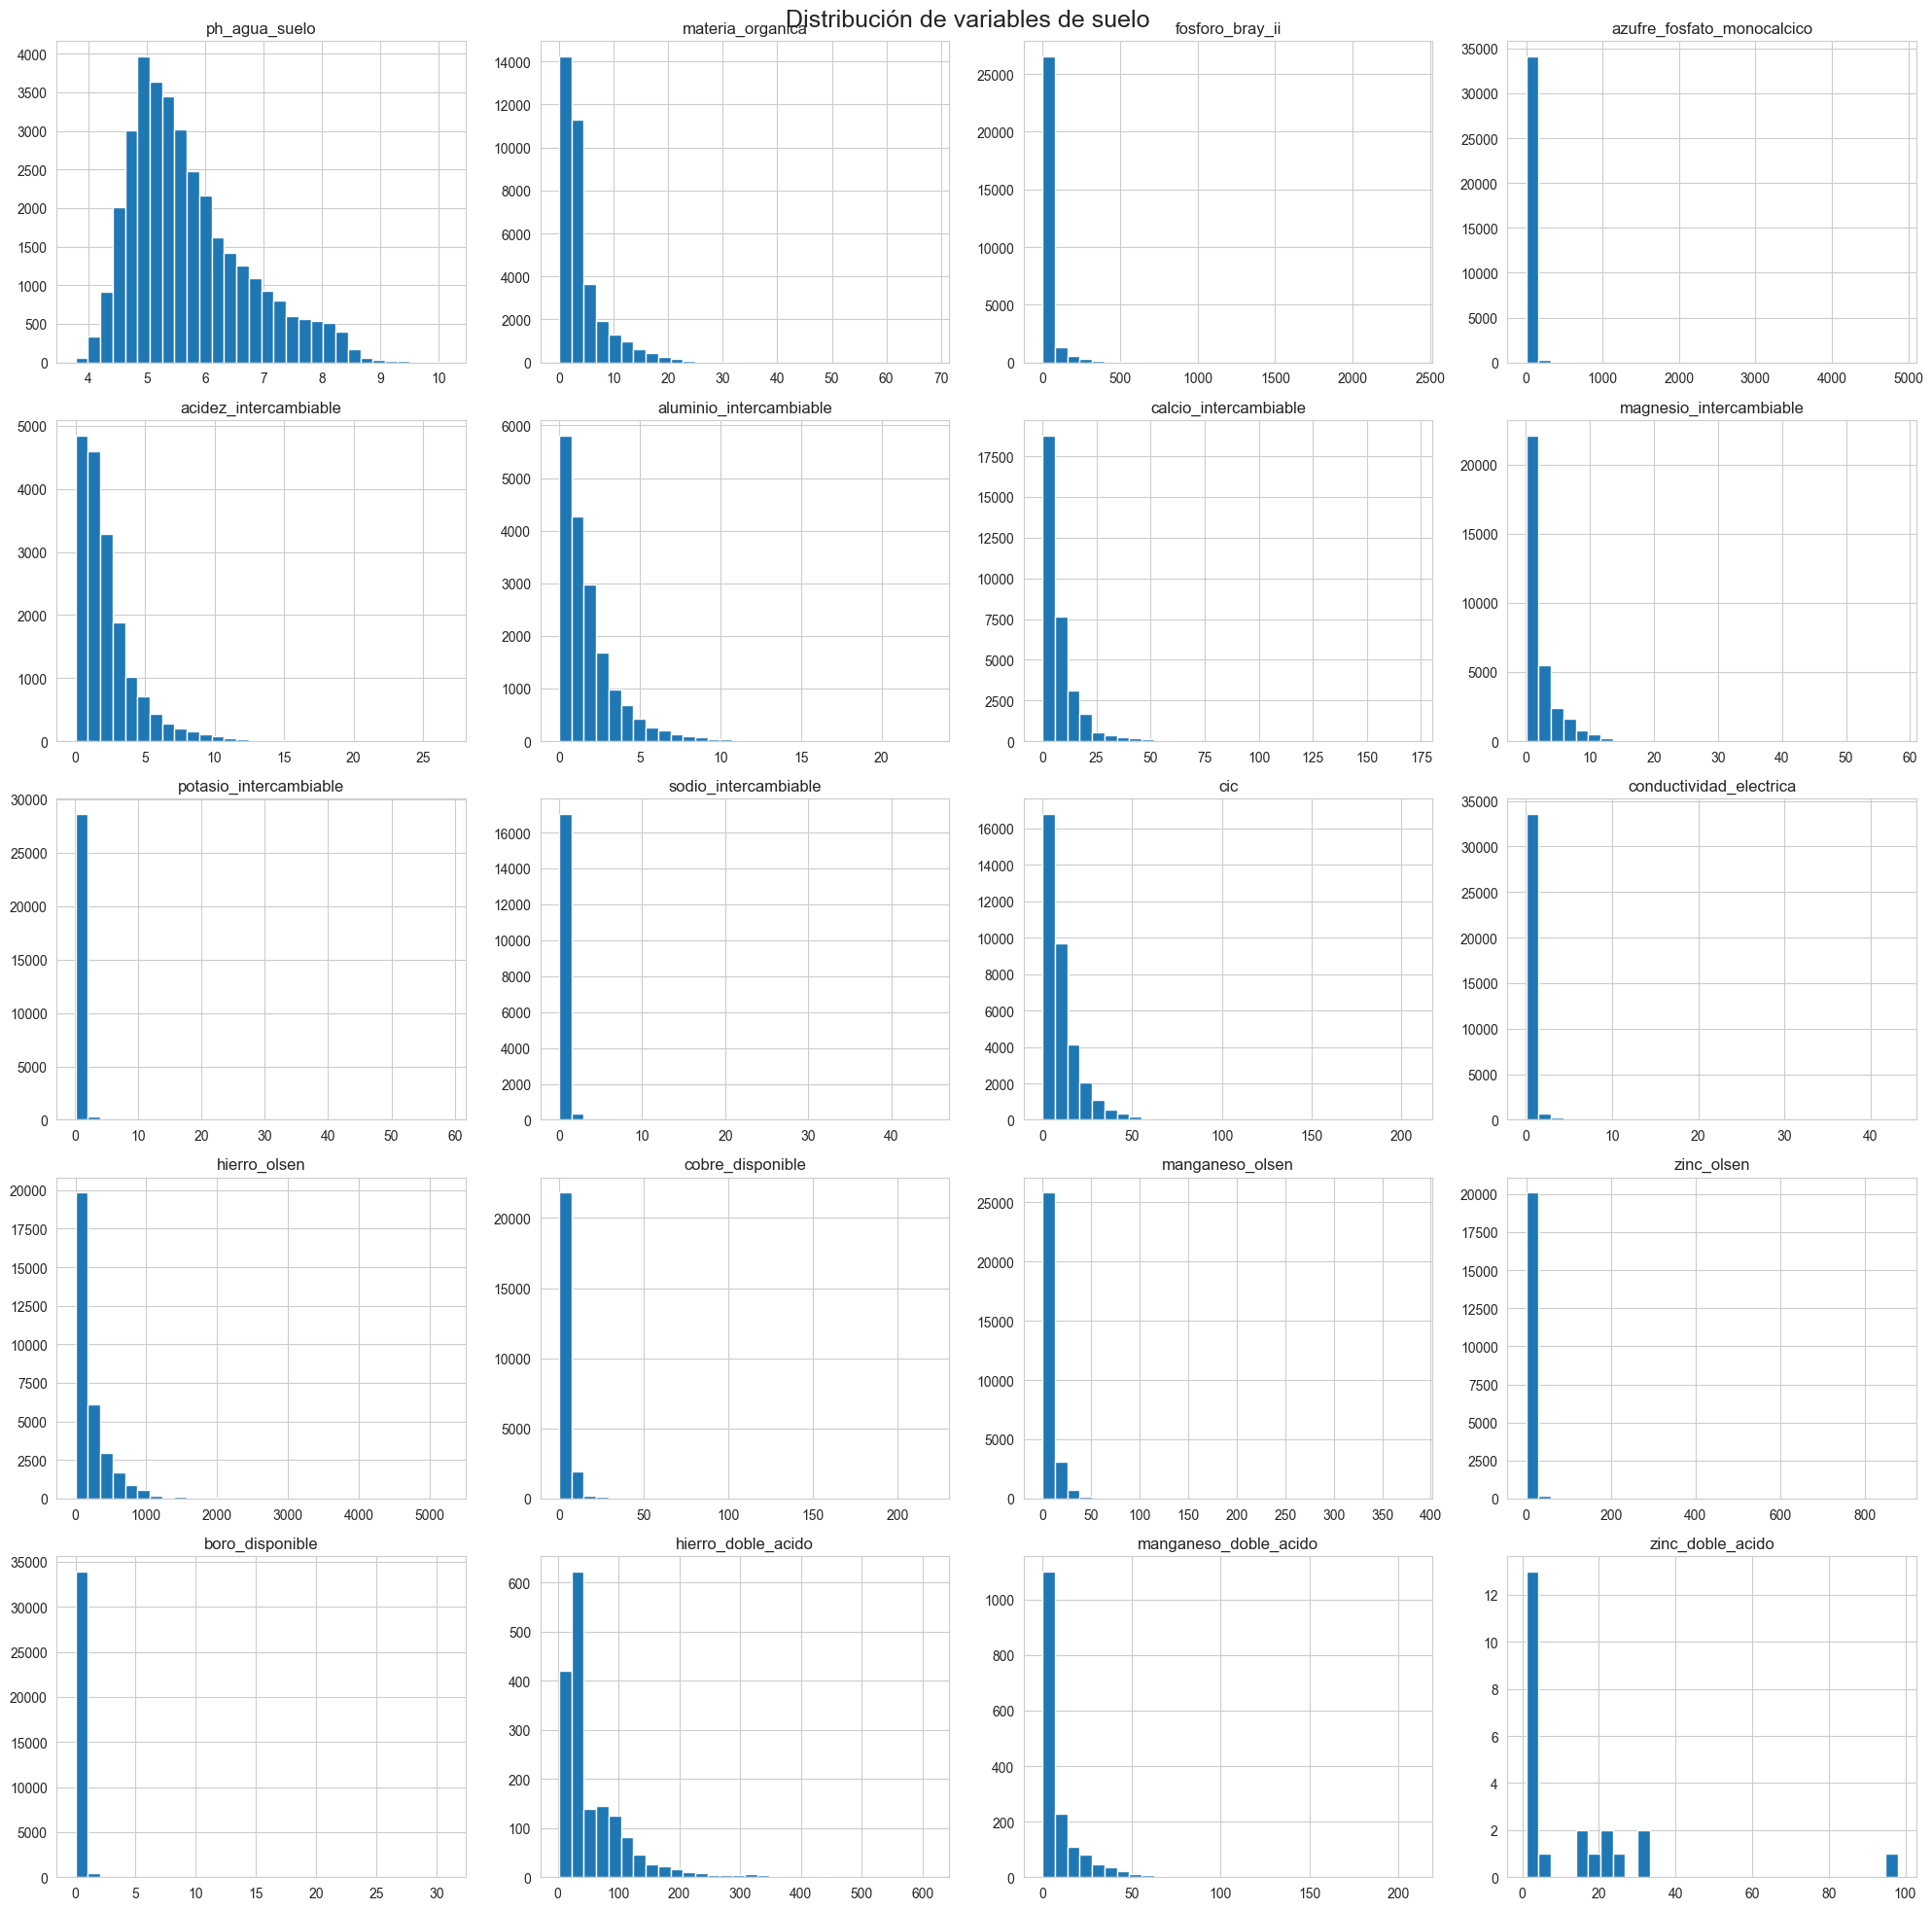

In [5]:
# Celda 4 - Histogramas de todas las variables de suelo

df[variables_presentes].hist(figsize=(20, 20), bins=30)
plt.suptitle("Distribución de variables de suelo", fontsize=18)
plt.tight_layout()
plt.show()


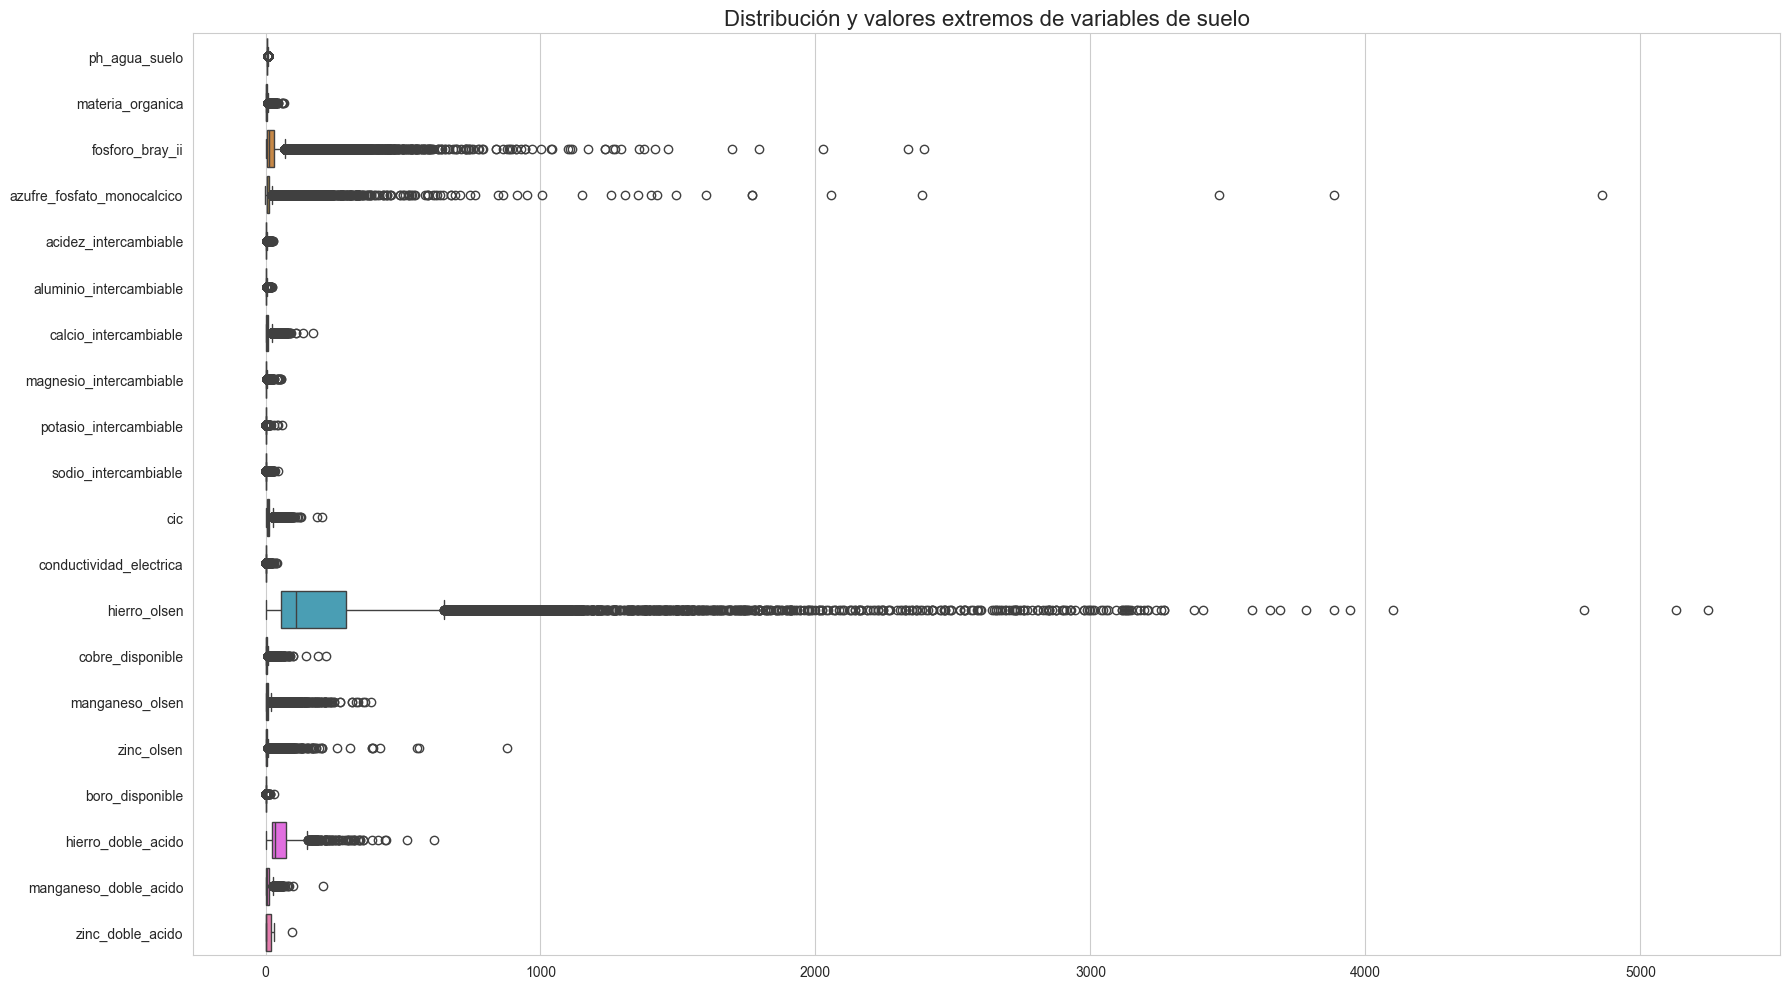

In [6]:
# Celda 4b - Boxplot global para detectar valores extremos

plt.figure(figsize=(18, 10))
sns.boxplot(data=df[variables_presentes], orient="h")
plt.title("Distribución y valores extremos de variables de suelo", fontsize=16)
plt.tight_layout()
plt.show()


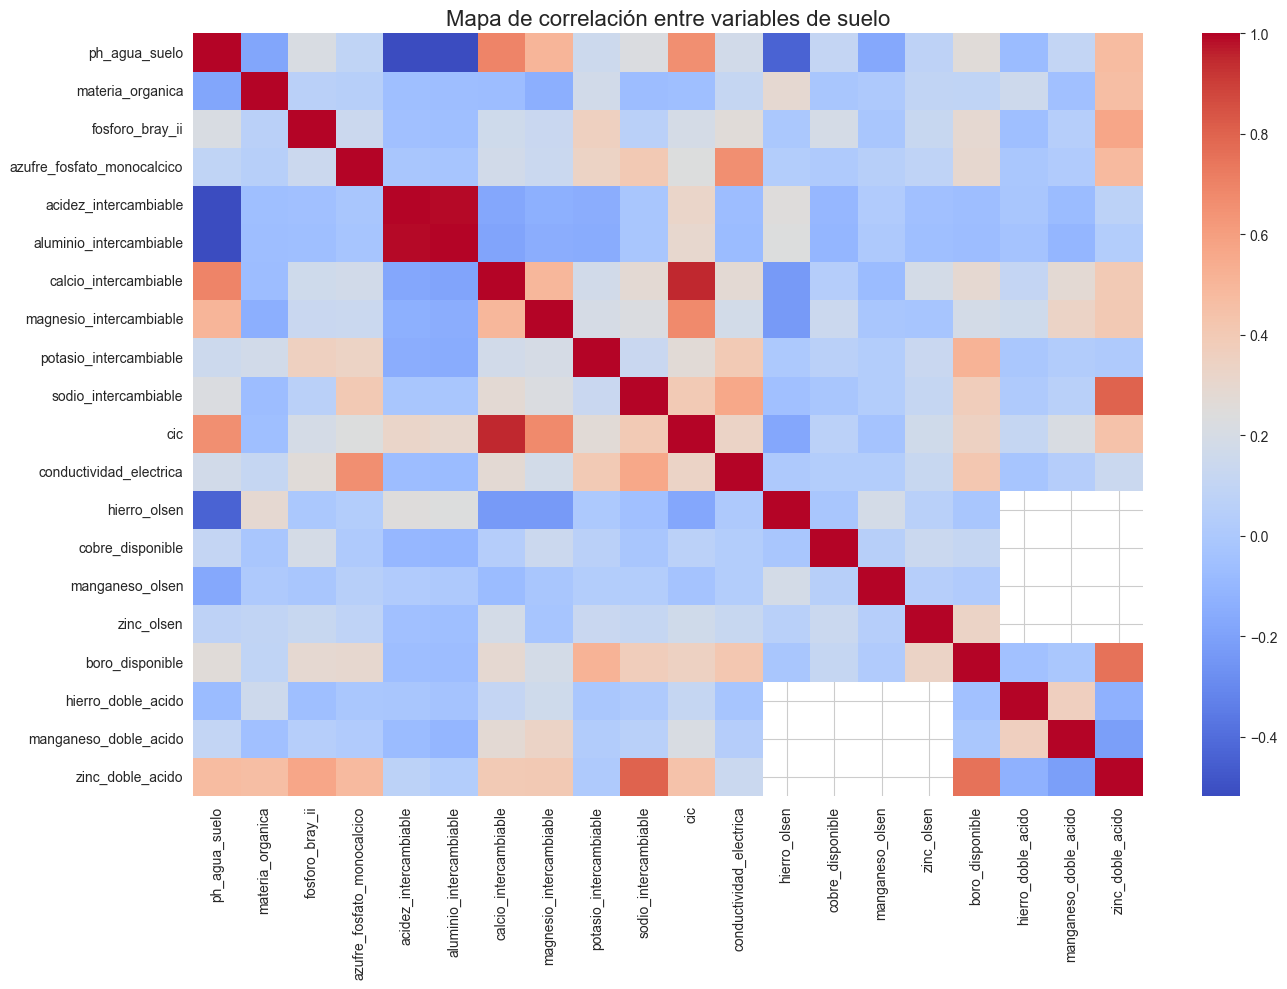

,var1,var2,correlacion
0,acidez_intercambiable,aluminio_intercambiable,0.990367
1,calcio_intercambiable,cic,0.951836


In [7]:
# Celda 5 - Matriz de correlación

corr = df[variables_presentes].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Mapa de correlación entre variables de suelo", fontsize=16)
plt.tight_layout()
plt.show()

# Pares de variables con |corr| > 0.8 (por ejemplo)
umbral = 0.8
pairs = []

for i, col1 in enumerate(variables_presentes):
    for col2 in variables_presentes[i+1:]:
        r = corr.loc[col1, col2]
        if abs(r) >= umbral:
            pairs.append((col1, col2, r))

corr_fuertes = pd.DataFrame(pairs, columns=["var1", "var2", "correlacion"])
corr_fuertes.sort_values("correlacion", key=np.abs, ascending=False)


In [8]:
# Celda 6 - Perfil de variables de suelo por departamento

if "departamento" not in df.columns:
    raise ValueError("No existe columna 'departamento' en los datos.")

perfil_departamento = (
    df.groupby("departamento")[variables_presentes]
      .agg(["mean", "count"])   # mean = valor promedio, count = # muestras
)

perfil_departamento.head()


ph_agua_suelo       materia_organica       fosforo_bray_ii        \
                      mean count             mean count            mean count   
departamento                                                                    
AMAZONAS          4.532222    45         2.225467    45        5.471282    39   
ANTIOQUIA         5.330822  3214         6.306752  3215       26.626554  2313   
ARAUCA            5.514254   489         1.237486   479       29.485868   454   
ATLÁNTICO         6.877926   271         1.584706   272       41.653921   241   
BOGOTÁ, D.C.      5.695768   211         6.518133   210       34.431055   200   

             azufre_fosfato_monocalcico       acidez_intercambiable        \
                                   mean count                  mean count   
departamento                                                                
AMAZONAS                       3.356791    43              6.621356    45   
ANTIOQUIA                     14.316545  3158              2.162459  2153   
ARAUCA                         7.043506   482              1.222236   254   
ATLÁNTICO                     80.802486   249              0.296857    14   
BOGOTÁ, D.C.                  12.003805   210              2.476354   113   

              ... zinc_olsen       boro_disponible       hierro_doble_acido  \
              ...       mean count            mean count               mean   
departamento  ...                                                             
AMAZONAS      ...   2.165235    17        0.160556    45                NaN   
ANTIOQUIA     ...   6.794365  1580        0.256301  3166                NaN   
ARAUCA        ...   3.960009   320        0.211300   483            98.3685   
ATLÁNTICO     ...   3.679663   166        0.495046   261                NaN   
BOGOTÁ, D.C.  ...   5.978118   153        0.239915   211                NaN   

                   manganeso_doble_acido       zinc_doble_acido        
             count                  mean count             mean count  
departamento                                                           
AMAZONAS         0                   NaN     0              NaN     0  
ANTIOQUIA        0                   NaN     0              NaN     0  
ARAUCA         100             26.455436   101              NaN     0  
ATLÁNTICO        0                   NaN     0              NaN     0  
BOGOTÁ, D.C.     0                   NaN     0              NaN     0  

[5 rows x 40 columns]

Ruta usada: D:\ICD-SOIL\data\geojson\colombia_departamentos.json
✅ GeoJSON cargado correctamente
Columnas del GeoJSON: ['source', 'id', 'name', 'geometry']


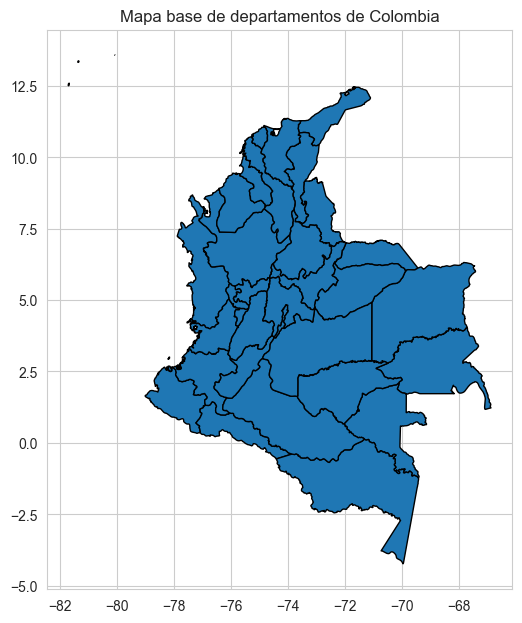

In [44]:
# Celda 7 - Cargar GeoJSON de departamentos

print("Ruta usada:", GEO_PATH.resolve())
if not GEO_PATH.exists():
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {GEO_PATH}")

gdf = gpd.read_file(GEO_PATH)

print("✅ GeoJSON cargado correctamente")
print("Columnas del GeoJSON:", list(gdf.columns))
gdf.head()

gdf.plot(figsize=(6, 10), edgecolor="black")
plt.title("Mapa base de departamentos de Colombia")
plt.show()


Ruta usada: D:\ICD-SOIL\data\geojson\colombia_departamentos.json
✅ GeoJSON cargado correctamente
Columnas del GeoJSON: ['source', 'id', 'name', 'geometry']


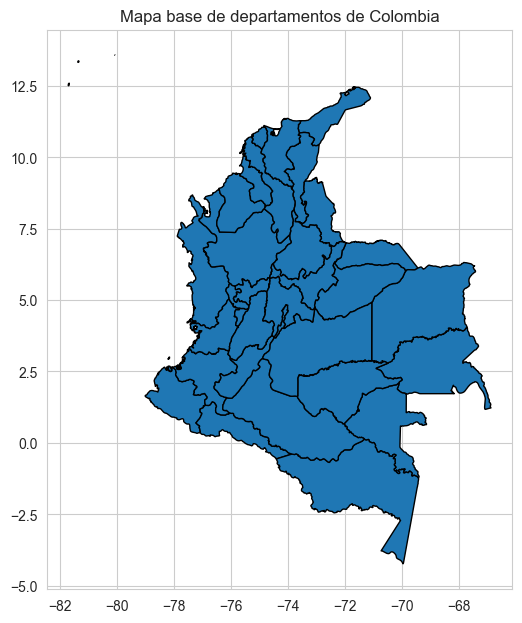

In [10]:
# Celda 7 - Cargar GeoJSON de departamentos

print("Ruta usada:", GEO_PATH.resolve())
if not GEO_PATH.exists():
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {GEO_PATH}")

gdf = gpd.read_file(GEO_PATH)

print("✅ GeoJSON cargado correctamente")
print("Columnas del GeoJSON:", list(gdf.columns))
gdf.head()

gdf.plot(figsize=(6, 10), edgecolor="black")
plt.title("Mapa base de departamentos de Colombia")
plt.show()


In [11]:
# Celda 8 - Normalización de nombres de departamento en df y gdf

def normalizar_departamento(nombre: str) -> str:
    if pd.isna(nombre):
        return nombre
    nombre = str(nombre).strip().upper()

    # quitar tildes
    nombre = unicodedata.normalize("NFKD", nombre)
    nombre = "".join(c for c in nombre if not unicodedata.combining(c))

    # quitar signos básicos
    nombre = re.sub(r"[.,;:]", " ", nombre)

    # colapsar espacios
    nombre = re.sub(r"\s+", " ", nombre).strip()
    return nombre

# 1) Detectar columna en GeoJSON
candidatas = [
    c for c in gdf.columns
    if any(k in c.lower() for k in ["depa", "dpto", "nombre", "name"])
]

if not candidatas:
    raise ValueError(f"No se encontró columna de nombre de departamento en gdf.columns: {list(gdf.columns)}")

geo_dep_col = candidatas[0]
print("Columna de nombre en GeoJSON:", geo_dep_col)

gdf["dep_norm"] = gdf[geo_dep_col].apply(normalizar_departamento)

# 2) Normalizar columna 'departamento' en df
df["dep_norm"] = df["departamento"].apply(normalizar_departamento)

# 3) Correcciones manuales
correcciones = {
    "BOGOTA D C": "BOGOTA DC",
    "BOGOTA D.C": "BOGOTA DC",
    "SANTAFE DE BOGOTA DISTRITO CAPITAL": "BOGOTA DC",
    "BOGOTA DISTRITO CAPITAL": "BOGOTA DC",
    "ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA": "SAN ANDRES Y PROVIDENCIA",
}

df["dep_norm"] = df["dep_norm"].replace(correcciones)
gdf["dep_norm"] = gdf["dep_norm"].replace(correcciones)

print("Ejemplos dep_norm en df:", sorted(df["dep_norm"].dropna().unique())[:10])
print("Ejemplos dep_norm en gdf:", sorted(gdf["dep_norm"].dropna().unique())[:10])


Columna de nombre en GeoJSON: name
Ejemplos dep_norm en df: ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTA DC', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE']
Ejemplos dep_norm en gdf: ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTA', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE']
